# Using Decision Tree & Naive Bayes to classify Legendary Pokemon

## Import libraries

In [214]:
# import gc
# import ast
# import math
# import numpy as np
# import pandas as pd
# import pandas_profiling as pdp
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from decisionTree import *

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
# Set packages options
# np.set_printoptions(threshold=np.nan)
pd.set_option("display.max_columns", 600)
plt.rcParams["figure.figsize"] = (11, 6)

## Define constants and functions

In [361]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

DropColumns = ["Pokedex#", "Name", "Type 1", "Type 2", "Generation", "Ability 1", "Ability 2", "Ability 3", 
               "EggGroup 1", "EggGroup 2", "Category", "Height (m)", "Weight (kg)"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getDistinctValues(dataFrame, columnName, sep):
    result = []
    for value in dataFrame[columnName].value_counts().index:
        result += value.split(sep)

    return set(result)

def splitData(dataFrame, trainingRatio):
    #assert trainingRatio + testRatio == 1.0, "Total ratio of training and test must add up to 1"
    msk = np.random.rand(len(dataFrame)) < trainingRatio
    return dataFrame[msk], dataFrame[~msk]

## Load the data from file and perform feature transformations

In [108]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes).fillna("None")
data.head()

# # Transform list of abilities and egg groups to "string" numeric values
# eggGroups = getDistinctValues(data, "EggGroups", "---")
# abilities = getDistinctValues(data, "Abilities", "---")

# eggGroupsMappings = {}
# for i, eg in enumerate(eggGroups): eggGroupsMappings[eg] = i    
    
# abilitiesMappings = {}
# for i, abil in enumerate(abilities): abilitiesMappings[abil] = i
    
# for i in range(len(data)):
#     numberStr = ""
#     values = sorted([abilitiesMappings[abil] for abil in data.loc[i, "Abilities"].split("---")])
#     val = ''.join(map(lambda x: str(x).zfill(3), values))
#     data.loc[i, "Abilities"] = val

# for i in range(len(data)):
#     numberStr = ""
#     values = sorted([eggGroupsMappings[eg] for eg in data.loc[i, "EggGroups"].split("---")])
#     val = ''.join(map(lambda x: str(x).zfill(3), values))
#     data.loc[i, "EggGroups"] = val

,Generation,Pokedex#,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,FemaleRatio,Height (m),Weight (kg),EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
0,1.0,1.0,Bulbasaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,12.5,0.7,6.9,Monster,Grass,45.0,49.0,49.0,65.0,65.0,45.0,318,Ordinary
1,1.0,2.0,Ivysaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,12.5,1.0,13.0,Monster,Grass,60.0,62.0,63.0,80.0,80.0,60.0,405,Ordinary
2,6.0,3.0,Mega Venusaur,Seed Pokemon,Grass,Poison,Thick Fat,None,None,87.5,12.5,2.0,100.0,Monster,Grass,80.0,100.0,123.0,122.0,120.0,80.0,625,Ordinary
3,1.0,3.0,Venusaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,12.5,2.0,100.0,Monster,Grass,80.0,82.0,83.0,100.0,100.0,80.0,525,Ordinary
4,1.0,4.0,Charmander,Lizard Pokemon,Fire,None,Blaze,Solar Power,None,87.5,12.5,0.6,8.5,Monster,Dragon,39.0,52.0,43.0,60.0,50.0,65.0,309,Ordinary


## Plot graphs to visualize and understand the data

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Group Types')]

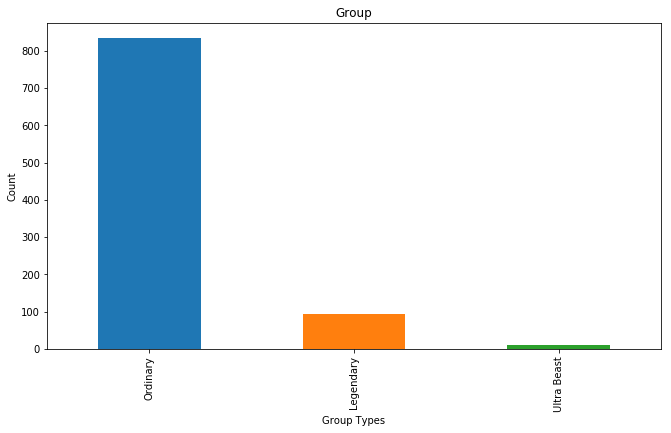

In [378]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = data["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")

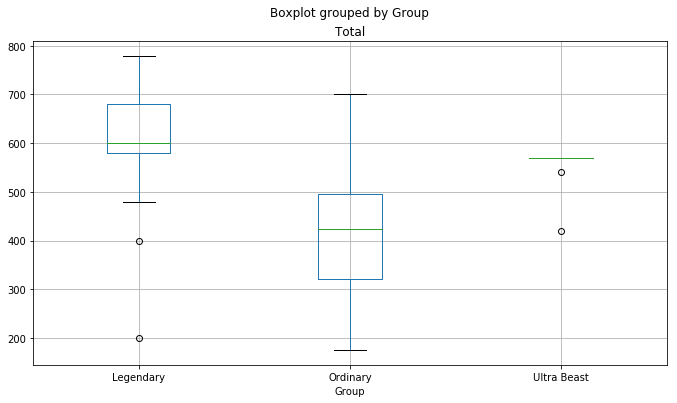

In [379]:
# Box plot Total & Group
data.boxplot("Total", "Group")

<p> According to the boxplot above, we can see that despite having a small quanity in size, Legendary Pokemon has the highest Total stats compared to the other 2 groups.</p>

## PCA

In [ ]:
reducedData = data.drop(DropColumns, axis=1)
dummies = pd.get_dummies(data[["Type 1", "Type 2", "Ability 1", "Ability 2", "Ability 3", "EggGroup 1", "EggGroup 2"]])
dataWithDummies = pd.concat([dummies, reducedData], axis=1, join_axes=[reducedData.index])

x = dataWithDummies.loc[:, dataWithDummies.columns != "Group"]
y = dataWithDummies.loc[:, "Group"]

# Scale the x data
#x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(x)
width, height = principalComponents.shape
principalDf = pd.DataFrame(data=principalComponents, columns=["pca %d" % i for i in range(1, height + 1)])
pcaData = pd.concat([principalDf, dataWithDummies[["Group"]]], axis=1)

xTrain = pcaData.sample(frac=0.5)

In [ ]:
# # Plot Type 1 and Type 2 occurences to see the distributions
# typeFig, typeAxes = plt.subplots(nrows=3, ncols=1)
# typeFig.subplots_adjust(top=3)

# type1Counts = data["Type 1"].value_counts()
# type2Counts = data["Type 2"].value_counts().drop("None")
# typesCounts = type1Counts.add(type2Counts, fill_value=0)

# type1Counts.plot(title="Type 1 Occurrences", kind="bar", ax=typeAxes[0], color=getColorList(type1Counts))
# type2Counts.plot(title="Type 2 Occurrences", kind="bar", ax=typeAxes[1], color=getColorList(type2Counts))
# typesCounts.plot(title="Type 1 + 2 Occurrences", kind="bar", ax=typeAxes[2], color=getColorList(typesCounts))

# fh = FeatureHasher(n_features=2, input_type="string")
# hashedFeature1 = fh.fit_transform(data["Type 1"])
# hashedFeature2 = fh.fit_transform(data["Type 2"])

# x = pd.concat([data[["Name", "Type 1", "Type 2", "Category"]], pd.DataFrame(hashedFeature1.toarray())], axis=1)
# x = pd.concat([x, pd.DataFrame(hashedFeature2.toarray())], axis=1)


## Decision Tree

In [365]:
# x = data.loc[:, data.columns != "Group"].fillna("None")
# y = data.loc[:, "Group"]

# training = data.sample(439)
training, test = splitData(data, 0.7)

In [369]:
dt = DecisionTree("Group")
node = dt.train(training)

# dt.findBestFeature(training)

# impurity = dt.giniImpurity(training)
# left, right = dt.partition(training, "EggGroup 1", "Monster")
# left, right = dt.partition(training, "Total", 0.8)
# ig = dt.informationGain(left, right, impurity)
# ig

Best feature EggGroup 1
Best feature Total
Best feature Ability 1
Best feature None
Best feature Name
Best feature None
Best feature None
Best feature Generation
Best feature None
Best feature None
Best feature Name
Best feature None
Best feature Name
Best feature None
Best feature None


In [370]:
c = dt.classify(test, node)


In [377]:
for k,v in c.items():
    if (v.index[0] == "Legendary") or (v.index[0] == "Ultra Beast"):
        print(k, "--->", v.index[0])

Nidorina ---> Legendary
Zapdos ---> Legendary
Mega Mewtwo Y ---> Legendary
Mew ---> Legendary
Unown ---> Legendary
Elekid ---> Legendary
Magby ---> Legendary
Entei ---> Legendary
Suicune ---> Legendary
Lugia ---> Legendary
Celebi ---> Legendary
Mega Latios ---> Legendary
Kyogre ---> Legendary
Mega Rayquaza ---> Legendary
Deoxys ---> Legendary
Munchlax ---> Legendary
Mantyke ---> Legendary
Giratina Altered Form ---> Legendary
Darkrai ---> Legendary
Arceus ---> Legendary
Victini ---> Legendary
Cobalion ---> Legendary
Tornadus Incarnate Form ---> Legendary
Landorus Therian Form ---> Legendary
Kyurem ---> Legendary
White Kyurem ---> Legendary
Yveltal ---> Legendary
Zygarde 50% Form ---> Legendary
Zygarde 10% Form ---> Legendary
Zygarde Complete Form ---> Legendary
Volcanion ---> Legendary
Tapu Koko ---> Legendary
Buzzwole ---> Ultra Beast
Guzzlord ---> Ultra Beast
Dawn Wings Necrozma ---> Legendary
Magearna ---> Legendary
Stakataka ---> Ultra Beast


In [ ]:
# Get data profile
profile = pdp.ProfileReport(dataWithDummies)
profile.to_file("Profile.html")
profile = None
gc.collect()